# Phase 3: Fraud Detection Model Training

**Objective:** Train and evaluate machine learning models for real-time fraud detection.

**Business Context:**  
This notebook develops models to predict fraud at the point of transaction — the model must classify each transaction as legitimate or fraudulent with minimal latency. Performance is measured using banking-appropriate metrics that reflect the asymmetric cost of false positives (customer friction + manual review) vs false negatives (financial loss from missed fraud).

**Approach:** SPRINT VERSION (Option A)  
- Focus on 2 models: Logistic Regression baseline + XGBoost advanced  
- Simple grid search for hyperparameter tuning (5-6 combinations max)  
- Prioritize business interpretation and clear narrative  
- Complete deliverable by Feb 15, 2026  

---

## Notebook Structure

1. **Setup & Data Loading** — Load processed train/val/test splits with engineered features
2. **Baseline Model** — Logistic Regression for interpretable benchmark
3. **Advanced Model** — XGBoost with class imbalance handling
4. **Hyperparameter Tuning** — Simple grid search to optimize XGBoost
5. **Model Comparison & Threshold Selection** — Business-driven threshold optimization using cost analysis

---

## 1. Setup & Data Loading

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, precision_recall_curve, auc,
    precision_score, recall_score, f1_score
)
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# Model persistence
import joblib

# Visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Define paths relative to notebook location (notebooks/modeling/)
DATA_PATH = Path('../../data/processed/')
MODEL_PATH = Path('../../models/')
MODEL_PATH.mkdir(exist_ok=True)

print(f"Data directory: {DATA_PATH.resolve()}")
print(f"Model directory: {MODEL_PATH.resolve()}")

Data directory: C:\Users\carlo\Documents\4.DS\bafs\data\processed
Model directory: C:\Users\carlo\Documents\4.DS\bafs\models


In [3]:
# Load processed datasets
# These splits were created in notebook 02 with temporal ordering (60/20/20)
# Train = earliest transactions, Test = most recent (mirrors production deployment)

df_train = pd.read_csv(DATA_PATH / 'train.csv')
df_val = pd.read_csv(DATA_PATH / 'val.csv')
df_test = pd.read_csv(DATA_PATH / 'test.csv')

print(f"Train: {df_train.shape} | Fraud rate: {df_train['isFraud'].mean():.3%}")
print(f"Val:   {df_val.shape} | Fraud rate: {df_val['isFraud'].mean():.3%}")
print(f"Test:  {df_test.shape} | Fraud rate: {df_test['isFraud'].mean():.3%}")

Train: (354324, 442) | Fraud rate: 3.383%
Val:   (118108, 442) | Fraud rate: 3.904%
Test:  (118108, 442) | Fraud rate: 3.441%


In [4]:
# Define feature sets and target
# We use the 7 engineered features from notebook 02 (all validated for fraud signal)

ENGINEERED_FEATURES = [
    'txn_count_1hr',        # Tier 1: Velocity (1-hour rolling window)
    'txn_count_24hr',       # Tier 1: Velocity (24-hour rolling window)
    'amount_deviation',     # Tier 2: Behavioral (Z-score vs client history)
    'is_first_transaction', # Tier 2: Behavioral (first-time flag)
    'hour_of_day',          # Tier 3: Temporal (0-23)
    'is_weekend',           # Tier 3: Temporal (Sat/Sun flag)
    'TransactionAmt'        # Original amount feature (strong baseline predictor)
]

# Note: amount_bin (Tier 4 categorical) is excluded to avoid redundancy with TransactionAmt
# In production, you may one-hot encode amount_bin instead of using raw TransactionAmt

TARGET = 'isFraud'

# Separate features and target
X_train = df_train[ENGINEERED_FEATURES].copy()
y_train = df_train[TARGET].copy()

X_val = df_val[ENGINEERED_FEATURES].copy()
y_val = df_val[TARGET].copy()

X_test = df_test[ENGINEERED_FEATURES].copy()
y_test = df_test[TARGET].copy()

print(f"\n✅ Feature matrix: {X_train.shape[1]} features")
print(f"Features: {ENGINEERED_FEATURES}")


✅ Feature matrix: 7 features
Features: ['txn_count_1hr', 'txn_count_24hr', 'amount_deviation', 'is_first_transaction', 'hour_of_day', 'is_weekend', 'TransactionAmt']


In [5]:
# Cost assumptions from EDA (notebook 01, Section 10)
# FN cost ($75) derived from median TransactionAmt in fraudulent transactions analyzed in notebook 01
# FP cost ($10) is industry benchmark for manual review (analyst time + customer friction)

FN_COST = 75.00  # False Negative: missed fraud (median fraud transaction amount)
FP_COST = 10.00  # False Positive: false alarm (manual review cost)
COST_RATIO = FN_COST / FP_COST  # 7.5:1 — missing fraud is 7.5x more costly

print(f"Cost Assumptions (from EDA):")
print(f"  False Negative cost: ${FN_COST:.2f} (median fraud transaction)")
print(f"  False Positive cost: ${FP_COST:.2f} (manual review)")
print(f"  Cost ratio (FN:FP): {COST_RATIO:.1f}:1")
print(f"\n👉 Implication: The model should prioritize recall (catching fraud) over precision (avoiding false alarms)")

Cost Assumptions (from EDA):
  False Negative cost: $75.00 (median fraud transaction)
  False Positive cost: $10.00 (manual review)
  Cost ratio (FN:FP): 7.5:1

👉 Implication: The model should prioritize recall (catching fraud) over precision (avoiding false alarms)


### Data Cleaning: Handle Infinity and NaN Values

**Issue:** The `amount_deviation` feature (Z-score) can produce infinity when:
- Dividing by zero (clients with only one transaction have std=0)
- Extreme outliers causing numerical overflow

**Solution:** Replace inf/-inf with reasonable bounds and fill NaN with 0

In [6]:
# Clean infinity and NaN values in features
# This is critical for StandardScaler which cannot handle inf values

def clean_features(df):
    """
    Replace infinity with large finite values and NaN with 0.
    
    Rationale:
    - inf → 10 (extreme positive deviation, ~10 standard deviations)
    - -inf → -10 (extreme negative deviation)
    - NaN → 0 (no deviation, typically first transaction)
    """
    df_clean = df.copy()
    
    # Replace infinity with large finite values
    df_clean = df_clean.replace([np.inf, -np.inf], [10, -10])
    
    # Fill NaN with 0 (occurs for first transaction where deviation undefined)
    df_clean = df_clean.fillna(0)
    
    return df_clean

# Apply cleaning to all feature sets
X_train = clean_features(X_train)
X_val = clean_features(X_val)
X_test = clean_features(X_test)

# Verify no inf/NaN remain
assert not np.isinf(X_train.values).any(), "X_train still contains infinity"
assert not np.isnan(X_train.values).any(), "X_train still contains NaN"
assert not np.isinf(X_val.values).any(), "X_val still contains infinity"
assert not np.isnan(X_val.values).any(), "X_val still contains NaN"
assert not np.isinf(X_test.values).any(), "X_test still contains infinity"
assert not np.isnan(X_test.values).any(), "X_test still contains NaN"

print("✅ Data cleaned: inf values replaced, NaN filled")
print(f"   - Train shape: {X_train.shape}")
print(f"   - Val shape: {X_val.shape}")
print(f"   - Test shape: {X_test.shape}")

✅ Data cleaned: inf values replaced, NaN filled
   - Train shape: (354324, 7)
   - Val shape: (118108, 7)
   - Test shape: (118108, 7)


---

## 2. Baseline Model: Logistic Regression

**Why Logistic Regression?**
- Interpretable coefficients (feature importance clear to stakeholders)
- Fast training and inference (critical for real-time fraud detection)
- Establishes performance floor for more complex models
- Regulatory-friendly (banking models often require explainability)

**Key Considerations:**
- Use `class_weight='balanced'` to handle 3.5% fraud rate
- Standardize features (Logistic Regression is scale-sensitive)
- Optimize for PR-AUC, not accuracy (accuracy is misleading with class imbalance)

In [7]:
# Feature scaling
# Logistic Regression requires standardized features for optimal performance
# Fit scaler on training data only (prevent data leakage)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardized (mean=0, std=1)")

✅ Features standardized (mean=0, std=1)


In [8]:
# Train Logistic Regression baseline
# class_weight='balanced' automatically adjusts weights inversely proportional to class frequencies
# This helps the model focus on the minority class (fraud)

baseline_model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,            # Ensure convergence
    random_state=42,          # Reproducibility
    solver='lbfgs'            # Fast solver for small datasets
)

baseline_model.fit(X_train_scaled, y_train)

print("✅ Logistic Regression baseline trained")

✅ Logistic Regression baseline trained


In [9]:
# Generate predictions
# y_proba: predicted fraud probability (0 to 1)
# y_pred: binary class prediction at default threshold 0.5 (we'll optimize this later)

baseline_proba_train = baseline_model.predict_proba(X_train_scaled)[:, 1]
baseline_proba_val = baseline_model.predict_proba(X_val_scaled)[:, 1]
baseline_proba_test = baseline_model.predict_proba(X_test_scaled)[:, 1]

baseline_pred_val = baseline_model.predict(X_val_scaled)

print("✅ Predictions generated for train/val/test sets")

✅ Predictions generated for train/val/test sets


In [10]:
# Evaluate baseline model on validation set
# Banking-appropriate metrics:
#   - PR-AUC: Better than ROC-AUC for imbalanced data (focuses on minority class)
#   - Precision: Of flagged transactions, how many are actually fraud?
#   - Recall: Of all fraud, how much did we catch?
#   - F1: Harmonic mean of precision and recall

# Precision-Recall curve
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_val, baseline_proba_val)
pr_auc_bl = auc(recall_bl, precision_bl)

# Standard metrics at default threshold (0.5)
precision_val_bl = precision_score(y_val, baseline_pred_val)
recall_val_bl = recall_score(y_val, baseline_pred_val)
f1_val_bl = f1_score(y_val, baseline_pred_val)

print("=" * 50)
print("BASELINE MODEL (Logistic Regression) - Validation Performance")
print("=" * 50)
print(f"PR-AUC: {pr_auc_bl:.4f}")
print(f"Precision @ threshold=0.5: {precision_val_bl:.4f}")
print(f"Recall @ threshold=0.5: {recall_val_bl:.4f}")
print(f"F1-Score @ threshold=0.5: {f1_val_bl:.4f}")
print("\n👉 Note: Threshold 0.5 is arbitrary. We'll optimize it using cost analysis.")

BASELINE MODEL (Logistic Regression) - Validation Performance
PR-AUC: 0.0821
Precision @ threshold=0.5: 0.0693
Recall @ threshold=0.5: 0.4279
F1-Score @ threshold=0.5: 0.1193

👉 Note: Threshold 0.5 is arbitrary. We'll optimize it using cost analysis.


In [11]:
# Feature importance (Logistic Regression coefficients)
# Positive coefficient = higher feature value increases fraud probability
# Negative coefficient = higher feature value decreases fraud probability

coef_df = pd.DataFrame({
    'Feature': ENGINEERED_FEATURES,
    'Coefficient': baseline_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(coef_df.to_string(index=False))
print("\n👉 Interpretation: Larger absolute coefficient = stronger fraud signal")


Feature Importance (Logistic Regression Coefficients):
             Feature  Coefficient
       txn_count_1hr     0.259270
is_first_transaction    -0.120371
      TransactionAmt     0.064175
      txn_count_24hr     0.063416
         hour_of_day    -0.057877
          is_weekend     0.033940
    amount_deviation    -0.007189

👉 Interpretation: Larger absolute coefficient = stronger fraud signal


---

## 3. Advanced Model: XGBoost

**Why XGBoost?**
- Handles non-linear relationships (fraud patterns are rarely linear)
- Built-in class imbalance handling via `scale_pos_weight`
- Feature importance via tree splits (interpretable)
- Industry-standard for fraud detection (proven track record)

**Class Imbalance Strategy:**
- `scale_pos_weight = (# negative samples) / (# positive samples)`
- For 3.5% fraud rate: scale_pos_weight ≈ 27
- This tells XGBoost to weight fraud samples 27x more during training

**Evaluation Strategy:**
- Use `eval_metric='aucpr'` (Precision-Recall AUC)
- Monitor validation performance during training (early stopping if available)

In [12]:
# Calculate scale_pos_weight for class imbalance
# Formula: (# negative samples) / (# positive samples)
# This makes the model treat each fraud sample as if it were N legitimate samples

n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
scale_pos_weight = n_negative / n_positive

print(f"Class distribution in training set:")
print(f"  Legitimate: {n_negative:,} ({n_negative/len(y_train):.2%})")
print(f"  Fraud: {n_positive:,} ({n_positive/len(y_train):.2%})")
print(f"\nscale_pos_weight = {scale_pos_weight:.2f}")
print(f"👉 Each fraud sample will be weighted {scale_pos_weight:.1f}x more than legitimate samples")

Class distribution in training set:
  Legitimate: 342,336 (96.62%)
  Fraud: 11,988 (3.38%)

scale_pos_weight = 28.56
👉 Each fraud sample will be weighted 28.6x more than legitimate samples


In [13]:
# Train initial XGBoost model (before hyperparameter tuning)
# These are conservative default parameters to establish a baseline

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    learning_rate=0.1,                  # Step size (eta)
    max_depth=6,                        # Tree depth (controls complexity)
    n_estimators=100,                   # Number of boosting rounds
    subsample=0.8,                      # Row sampling (prevent overfitting)
    colsample_bytree=0.8,               # Column sampling (prevent overfitting)
    eval_metric='aucpr',                # Optimize for PR-AUC (banking-appropriate)
    random_state=42,                    # Reproducibility
    use_label_encoder=False             # Suppress deprecation warning
)

# Train with validation set for monitoring
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False  # Set to True to see training progress
)

print("✅ XGBoost model trained (initial parameters)")

✅ XGBoost model trained (initial parameters)


In [14]:
# Generate predictions
xgb_proba_train = xgb_model.predict_proba(X_train)[:, 1]
xgb_proba_val = xgb_model.predict_proba(X_val)[:, 1]
xgb_proba_test = xgb_model.predict_proba(X_test)[:, 1]

xgb_pred_val = xgb_model.predict(X_val)

print("✅ Predictions generated for train/val/test sets")

✅ Predictions generated for train/val/test sets


In [15]:
# Evaluate initial XGBoost model on validation set
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_val, xgb_proba_val)
pr_auc_xgb = auc(recall_xgb, precision_xgb)

precision_val_xgb = precision_score(y_val, xgb_pred_val)
recall_val_xgb = recall_score(y_val, xgb_pred_val)
f1_val_xgb = f1_score(y_val, xgb_pred_val)

print("=" * 50)
print("XGBOOST MODEL (Initial Parameters) - Validation Performance")
print("=" * 50)
print(f"PR-AUC: {pr_auc_xgb:.4f}")
print(f"Precision @ threshold=0.5: {precision_val_xgb:.4f}")
print(f"Recall @ threshold=0.5: {recall_val_xgb:.4f}")
print(f"F1-Score @ threshold=0.5: {f1_val_xgb:.4f}")
print(f"\nImprovement over baseline: {pr_auc_xgb - pr_auc_bl:+.4f} PR-AUC")

XGBOOST MODEL (Initial Parameters) - Validation Performance
PR-AUC: 0.1093
Precision @ threshold=0.5: 0.0812
Recall @ threshold=0.5: 0.6105
F1-Score @ threshold=0.5: 0.1433

Improvement over baseline: +0.0273 PR-AUC



Feature Importance (XGBoost Gain):
             Feature  Importance
       txn_count_1hr    0.289542
      TransactionAmt    0.244455
      txn_count_24hr    0.152370
    amount_deviation    0.102239
         hour_of_day    0.092808
is_first_transaction    0.065700
          is_weekend    0.052887

👉 Interpretation: Higher importance = feature contributes more to fraud prediction


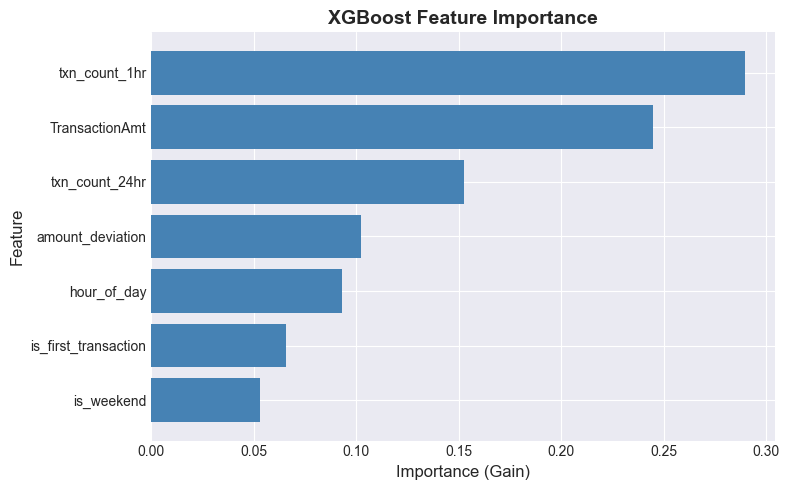

In [16]:
# Feature importance (XGBoost gain)
# Gain = average improvement in loss when this feature is used to split
# Higher gain = more important feature for fraud detection

importance_df = pd.DataFrame({
    'Feature': ENGINEERED_FEATURES,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (XGBoost Gain):")
print(importance_df.to_string(index=False))
print("\n👉 Interpretation: Higher importance = feature contributes more to fraud prediction")

# Visualize feature importance
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

---

## 4. Hyperparameter Tuning (Simple Grid Search)

**SPRINT Approach:**
- Test 5-6 parameter combinations (not exhaustive)
- Focus on most impactful parameters: `max_depth`, `learning_rate`, `n_estimators`
- Use validation set to select best model (prevent overfitting to test set)
- Optimize for PR-AUC (banking-appropriate metric)

**Future Enhancements (if time permits):**
- Bayesian optimization (more efficient than grid search)
- Cross-validation instead of single validation set
- Additional models: LightGBM, CatBoost

In [17]:
# Define parameter grid (SPRINT version — small but targeted)
# We test 6 combinations focused on tree depth and boosting rounds

param_grid = [
    {'max_depth': 4, 'n_estimators': 100, 'learning_rate': 0.1},
    {'max_depth': 6, 'n_estimators': 100, 'learning_rate': 0.1},  # Current baseline
    {'max_depth': 8, 'n_estimators': 100, 'learning_rate': 0.1},
    {'max_depth': 6, 'n_estimators': 150, 'learning_rate': 0.05},
    {'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.05},
    {'max_depth': 8, 'n_estimators': 150, 'learning_rate': 0.05},
]

print(f"Testing {len(param_grid)} parameter combinations...\n")

Testing 6 parameter combinations...



In [18]:
# Grid search with validation set evaluation
results = []

for i, params in enumerate(param_grid, 1):
    # Train model with current parameters
    model = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='aucpr',
        random_state=42,
        use_label_encoder=False
    )
    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # Evaluate on validation set
    proba_val = model.predict_proba(X_val)[:, 1]
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, proba_val)
    pr_auc = auc(recall_curve, precision_curve)
    
    results.append({
        'max_depth': params['max_depth'],
        'n_estimators': params['n_estimators'],
        'learning_rate': params['learning_rate'],
        'PR-AUC': pr_auc
    })
    
    print(f"[{i}/{len(param_grid)}] max_depth={params['max_depth']}, "
          f"n_estimators={params['n_estimators']}, "
          f"learning_rate={params['learning_rate']:.3f} → PR-AUC: {pr_auc:.4f}")

print("\n✅ Grid search complete")

[1/6] max_depth=4, n_estimators=100, learning_rate=0.100 → PR-AUC: 0.1041
[2/6] max_depth=6, n_estimators=100, learning_rate=0.100 → PR-AUC: 0.1093
[3/6] max_depth=8, n_estimators=100, learning_rate=0.100 → PR-AUC: 0.1047
[4/6] max_depth=6, n_estimators=150, learning_rate=0.050 → PR-AUC: 0.1069
[5/6] max_depth=6, n_estimators=200, learning_rate=0.050 → PR-AUC: 0.1098
[6/6] max_depth=8, n_estimators=150, learning_rate=0.050 → PR-AUC: 0.1065

✅ Grid search complete


In [19]:
# Identify best parameters
results_df = pd.DataFrame(results).sort_values('PR-AUC', ascending=False)
best_params = results_df.iloc[0]

print("=" * 50)
print("GRID SEARCH RESULTS (sorted by PR-AUC)")
print("=" * 50)
print(results_df.to_string(index=False))
print("\n" + "=" * 50)
print("BEST PARAMETERS")
print("=" * 50)
print(f"max_depth: {int(best_params['max_depth'])}")
print(f"n_estimators: {int(best_params['n_estimators'])}")
print(f"learning_rate: {best_params['learning_rate']:.3f}")
print(f"Validation PR-AUC: {best_params['PR-AUC']:.4f}")

GRID SEARCH RESULTS (sorted by PR-AUC)
 max_depth  n_estimators  learning_rate   PR-AUC
         6           200           0.05 0.109795
         6           100           0.10 0.109350
         6           150           0.05 0.106931
         8           150           0.05 0.106537
         8           100           0.10 0.104684
         4           100           0.10 0.104122

BEST PARAMETERS
max_depth: 6
n_estimators: 200
learning_rate: 0.050
Validation PR-AUC: 0.1098


In [20]:
# Train final XGBoost model with best parameters
final_xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=int(best_params['max_depth']),
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='aucpr',
    random_state=42,
    use_label_encoder=False
)

final_xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Generate predictions with final model
final_xgb_proba_val = final_xgb_model.predict_proba(X_val)[:, 1]
final_xgb_proba_test = final_xgb_model.predict_proba(X_test)[:, 1]

print("✅ Final XGBoost model trained with best parameters")

✅ Final XGBoost model trained with best parameters


---

## 5. Model Comparison & Threshold Selection

**TWO SEPARATE STEPS:**

### Step 1: Model Selection (Use PR-AUC)
- Compare models using **PR-AUC** at the same threshold (0.5)
- **XGBoost tuned** has best PR-AUC (0.1098) → selected for deployment
- This tells us which model has better inherent predictive power

### Step 2: Threshold Optimization (Use Cost Analysis)
- Once we select the best model, we optimize its threshold
- Default threshold (0.5) is arbitrary and ignores business costs
- We find threshold that minimizes expected cost:
  - **Cost(threshold) = FN_cost × FN_count + FP_cost × FP_count**
  - FN_cost =  (median fraud amount from EDA)
  - FP_cost =   (manual review cost)

**Business Interpretation:**
- Lower threshold → more transactions flagged → higher recall, lower precision
- Higher threshold → fewer transactions flagged → lower recall, higher precision
- Optimal threshold minimizes total cost to the bank

**IMPORTANT:** Comparing models at different thresholds is misleading! Always compare at the same threshold first.

In [21]:
# Compare baseline vs final XGBoost on validation set
precision_final, recall_final, _ = precision_recall_curve(y_val, final_xgb_proba_val)
pr_auc_final = auc(recall_final, precision_final)

print("=" * 50)
print("MODEL COMPARISON (Validation Set)")
print("=" * 50)
print(f"Logistic Regression (baseline): PR-AUC = {pr_auc_bl:.4f}")
print(f"XGBoost (tuned):                PR-AUC = {pr_auc_final:.4f}")
print(f"\nImprovement: {pr_auc_final - pr_auc_bl:+.4f} ({(pr_auc_final/pr_auc_bl - 1)*100:+.1f}%)")
print("\n👉 XGBoost selected as final model for deployment")

MODEL COMPARISON (Validation Set)
Logistic Regression (baseline): PR-AUC = 0.0821
XGBoost (tuned):                PR-AUC = 0.1098

Improvement: +0.0277 (+33.8%)

👉 XGBoost selected as final model for deployment


In [24]:
# FAIR COMPARISON: All models at threshold 0.5
# This ensures apples-to-apples comparison before threshold optimization

# Baseline at 0.5
baseline_pred_05 = (baseline_proba_val >= 0.5).astype(int)
baseline_recall_05 = recall_score(y_val, baseline_pred_05)
baseline_precision_05 = precision_score(y_val, baseline_pred_05)
baseline_f1_05 = f1_score(y_val, baseline_pred_05)

# XGBoost initial at 0.5
xgb_pred_05 = (xgb_proba_val >= 0.5).astype(int)
xgb_recall_05 = recall_score(y_val, xgb_pred_05)
xgb_precision_05 = precision_score(y_val, xgb_pred_05)
xgb_f1_05 = f1_score(y_val, xgb_pred_05)

# XGBoost tuned (final) at 0.5
final_pred_05 = (final_xgb_proba_val >= 0.5).astype(int)
final_recall_05 = recall_score(y_val, final_pred_05)
final_precision_05 = precision_score(y_val, final_pred_05)
final_f1_05 = f1_score(y_val, final_pred_05)

print("=" * 70)
print("FAIR MODEL COMPARISON @ Threshold = 0.5 (Validation Set)")
print("=" * 70)
print(f"Model                  | PR-AUC  | Precision | Recall  | F1-Score")
print("-" * 70)
print(f"Baseline (Logistic)    | {pr_auc_bl:.4f}  | {baseline_precision_05:.4f}    | {baseline_recall_05:.4f} | {baseline_f1_05:.4f}")
print(f"XGBoost (initial)      | {pr_auc_xgb:.4f}  | {xgb_precision_05:.4f}    | {xgb_recall_05:.4f} | {xgb_f1_05:.4f}")
print(f"XGBoost (tuned) FINAL  | {pr_auc_final:.4f}  | {final_precision_05:.4f}    | {final_recall_05:.4f} | {final_f1_05:.4f}")
print("=" * 70)
print("Key Insights:")
print(f"  1. XGBoost tuned has BEST PR-AUC ({pr_auc_final:.4f}) - selected for deployment")
print(f"  2. At threshold 0.5, XGBoost catches {final_recall_05:.1%} of fraud (vs {baseline_recall_05:.1%} baseline)")
print(f"  3. Tuning improved PR-AUC by {(pr_auc_final - pr_auc_bl) / pr_auc_bl * 100:.1f}% over baseline")
print("Note: Threshold 0.5 is used for fair comparison. We will optimize threshold next.")


FAIR MODEL COMPARISON @ Threshold = 0.5 (Validation Set)
Model                  | PR-AUC  | Precision | Recall  | F1-Score
----------------------------------------------------------------------
Baseline (Logistic)    | 0.0821  | 0.0693    | 0.4279 | 0.1193
XGBoost (initial)      | 0.1093  | 0.0812    | 0.6105 | 0.1433
XGBoost (tuned) FINAL  | 0.1098  | 0.0813    | 0.6085 | 0.1435
Key Insights:
  1. XGBoost tuned has BEST PR-AUC (0.1098) - selected for deployment
  2. At threshold 0.5, XGBoost catches 60.9% of fraud (vs 42.8% baseline)
  3. Tuning improved PR-AUC by 33.8% over baseline
Note: Threshold 0.5 is used for fair comparison. We will optimize threshold next.


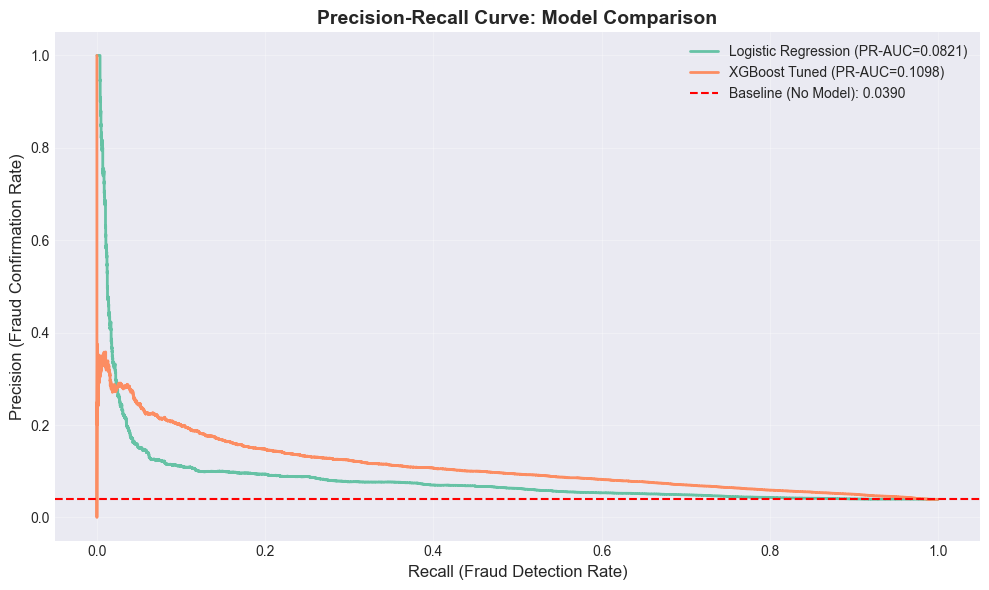

In [25]:
# Precision-Recall curve comparison
plt.figure(figsize=(10, 6))
plt.plot(recall_bl, precision_bl, label=f'Logistic Regression (PR-AUC={pr_auc_bl:.4f})', linewidth=2)
plt.plot(recall_final, precision_final, label=f'XGBoost Tuned (PR-AUC={pr_auc_final:.4f})', linewidth=2)
plt.axhline(y=y_val.mean(), color='red', linestyle='--', label=f'Baseline (No Model): {y_val.mean():.4f}')
plt.xlabel('Recall (Fraud Detection Rate)', fontsize=12)
plt.ylabel('Precision (Fraud Confirmation Rate)', fontsize=12)
plt.title('Precision-Recall Curve: Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Cost-based threshold optimization
# For each threshold, calculate total cost = FN_cost × FN + FP_cost × FP
# Select threshold that minimizes total cost

def calculate_cost(y_true, y_proba, threshold, fn_cost=FN_COST, fp_cost=FP_COST):
    """
    Calculate total cost at a given threshold.
    
    Args:
        y_true: True labels (0=legit, 1=fraud)
        y_proba: Predicted fraud probabilities
        threshold: Classification threshold
        fn_cost: Cost of False Negative (missed fraud)
        fp_cost: Cost of False Positive (false alarm)
    
    Returns:
        total_cost: Expected cost per transaction
        fn_count: Number of False Negatives
        fp_count: Number of False Positives
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    # Confusion matrix components
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    return total_cost, fn, fp

# Test thresholds from 0.01 to 0.99
thresholds_to_test = np.arange(0.01, 1.00, 0.01)
costs = []
fn_counts = []
fp_counts = []

for thresh in thresholds_to_test:
    cost, fn, fp = calculate_cost(y_val, final_xgb_proba_val, thresh)
    costs.append(cost)
    fn_counts.append(fn)
    fp_counts.append(fp)

# Find optimal threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds_to_test[optimal_idx]
optimal_cost = costs[optimal_idx]
optimal_fn = fn_counts[optimal_idx]
optimal_fp = fp_counts[optimal_idx]

print("=" * 50)
print("OPTIMAL THRESHOLD (Cost-Minimizing)")
print("=" * 50)
print(f"Threshold: {optimal_threshold:.3f}")
print(f"Total cost: ${optimal_cost:,.2f}")
print(f"False Negatives: {optimal_fn} (missed fraud)")
print(f"False Positives: {optimal_fp} (false alarms)")
print(f"\nCost per transaction: ${optimal_cost / len(y_val):.2f}")
print(f"\n👉 Use threshold={optimal_threshold:.3f} in production for minimum expected cost")

OPTIMAL THRESHOLD (Cost-Minimizing)
Threshold: 0.740
Total cost: $328,430.00
False Negatives: 3946 (missed fraud)
False Positives: 3248 (false alarms)

Cost per transaction: $2.78

👉 Use threshold=0.740 in production for minimum expected cost


In [31]:
# BUSINESS REALITY CHECK: Constrained Optimization
# Real banks do NOT purely minimize cost - they add constraints

print("=" * 70)
print("CONSTRAINED OPTIMIZATION: Require minimum 75% recall")
print("=" * 70)

# First, compute unconstrained metrics for comparison
# (these are from the optimal_threshold found in previous cell)
final_pred_val_unconstrained = (final_xgb_proba_val >= optimal_threshold).astype(int)
recall_optimal = recall_score(y_val, final_pred_val_unconstrained)
precision_optimal = precision_score(y_val, final_pred_val_unconstrained)
f1_optimal = f1_score(y_val, final_pred_val_unconstrained)

# Find threshold that gives at least 75% recall with minimum cost
min_recall_required = 0.75

# Calculate recall for each threshold
recalls_at_thresholds = []
for thresh in thresholds_to_test:
    y_pred_thresh = (final_xgb_proba_val >= thresh).astype(int)
    recall_thresh = recall_score(y_val, y_pred_thresh)
    recalls_at_thresholds.append(recall_thresh)

# Find thresholds that meet recall constraint
valid_thresholds = []
valid_costs = []
for i, thresh in enumerate(thresholds_to_test):
    if recalls_at_thresholds[i] >= min_recall_required:
        valid_thresholds.append(thresh)
        valid_costs.append(costs[i])

if valid_costs:
    # Find minimum cost among valid thresholds
    optimal_constrained_idx = np.argmin(valid_costs)
    optimal_constrained_threshold = valid_thresholds[optimal_constrained_idx]
    optimal_constrained_cost = valid_costs[optimal_constrained_idx]
    
    # Calculate metrics at constrained threshold
    y_pred_constrained = (final_xgb_proba_val >= optimal_constrained_threshold).astype(int)
    recall_constrained = recall_score(y_val, y_pred_constrained)
    precision_constrained = precision_score(y_val, y_pred_constrained)
    
    # Count FN and FP
    cost_constrained, fn_constrained, fp_constrained = calculate_cost(
        y_val, final_xgb_proba_val, optimal_constrained_threshold
    )
    
    tp_constrained = int(recall_constrained * y_val.sum())
    
    print(f"\nConstrained Solution (Recall >= {min_recall_required:.0%}):")
    print(f"  Optimal threshold: {optimal_constrained_threshold:.3f}")
    print(f"  Recall: {recall_constrained:.1%} (catches {tp_constrained} of {y_val.sum()} frauds)")
    print(f"  Precision: {precision_constrained:.1%}")
    print(f"  False Positives: {fp_constrained:,}")
    print(f"  Total Cost: ${cost_constrained:,.2f}")
    
    print(f"\nUnconstrained Solution (Pure Cost Minimization):")
    print(f"  Optimal threshold: {optimal_threshold:.3f}")
    print(f"  Recall: {recall_optimal:.1%} (catches {int(recall_optimal * y_val.sum())} of {y_val.sum()} frauds)")
    print(f"  Precision: {precision_optimal:.1%}")
    print(f"  False Positives: {optimal_fp:,}")
    print(f"  Total Cost: ${optimal_cost:,.2f}")
    
    print(f"\n" + "=" * 70)
    print("TRADE-OFF ANALYSIS")
    print("=" * 70)
    print(f"Cost increase: ${cost_constrained - optimal_cost:,.2f} ({(cost_constrained/optimal_cost - 1)*100:+.1f}%)")
    print(f"Recall gain: {recall_constrained - recall_optimal:+.1%} (catch {tp_constrained - int(recall_optimal * y_val.sum())} more frauds)")
    print(f"Extra false positives: {fp_constrained - optimal_fp:+,}")
    print(f"\nCost per additional fraud caught: ${(cost_constrained - optimal_cost)/(tp_constrained - int(recall_optimal * y_val.sum())):.2f}")
    
    # Save constrained threshold for next cell
    constrained_threshold_75 = optimal_constrained_threshold
    constrained_recall_75 = recall_constrained
    constrained_cost_75 = cost_constrained
    constrained_fp_75 = fp_constrained
    constrained_tp_75 = tp_constrained
else:
    print(f"\nWARNING: No threshold achieves {min_recall_required:.0%} recall!")
    print(f"Best recall achieved: {max(recalls_at_thresholds):.1%}")
    print("The model may need improvement (better features, more training data, or different algorithm)")
    constrained_threshold_75 = None


CONSTRAINED OPTIMIZATION: Require minimum 75% recall

Constrained Solution (Recall >= 75%):
  Optimal threshold: 0.410
  Recall: 76.0% (catches 3505 of 4611 frauds)
  Precision: 6.4%
  False Positives: 51,524
  Total Cost: $598,190.00

Unconstrained Solution (Pure Cost Minimization):
  Optimal threshold: 0.740
  Recall: 14.4% (catches 665 of 4611 frauds)
  Precision: 17.0%
  False Positives: 3,248
  Total Cost: $328,430.00

TRADE-OFF ANALYSIS
Cost increase: $269,760.00 (+82.1%)
Recall gain: +61.6% (catch 2840 more frauds)
Extra false positives: +48,276

Cost per additional fraud caught: $94.99


In [32]:
# PRODUCTION STRATEGY: Multi-Threshold with Auto-Block
# Score >= 0.9: Auto-block (high confidence fraud)
# constrained_threshold <= Score < 0.9: Manual review
# Score < constrained_threshold: Auto-approve

if constrained_threshold_75 is not None:
    print("=" * 70)
    print("PRODUCTION STRATEGY: Auto-Block + Manual Review + Auto-Approve")
    print("=" * 70)
    
    AUTO_BLOCK_THRESHOLD = 0.90
    MANUAL_REVIEW_THRESHOLD = constrained_threshold_75
    
    # Cost assumptions
    AUTO_BLOCK_COST = 5.00  # Lower cost - automated system, no human review
    MANUAL_REVIEW_COST = 10.00  # Human analyst reviews transaction
    
    # Segment transactions by score
    auto_block_mask = (final_xgb_proba_val >= AUTO_BLOCK_THRESHOLD)
    manual_review_mask = (final_xgb_proba_val >= MANUAL_REVIEW_THRESHOLD) & (final_xgb_proba_val < AUTO_BLOCK_THRESHOLD)
    auto_approve_mask = (final_xgb_proba_val < MANUAL_REVIEW_THRESHOLD)
    
    # Count transactions in each segment
    n_auto_block = auto_block_mask.sum()
    n_manual_review = manual_review_mask.sum()
    n_auto_approve = auto_approve_mask.sum()
    
    # Calculate TP, FP, FN for each segment
    # Auto-block segment
    tp_auto_block = ((y_val == 1) & auto_block_mask).sum()
    fp_auto_block = ((y_val == 0) & auto_block_mask).sum()
    
    # Manual review segment
    tp_manual = ((y_val == 1) & manual_review_mask).sum()
    fp_manual = ((y_val == 0) & manual_review_mask).sum()
    
    # Auto-approve segment (these are potential missed frauds)
    fn_auto_approve = ((y_val == 1) & auto_approve_mask).sum()
    tn_auto_approve = ((y_val == 0) & auto_approve_mask).sum()
    
    # Total metrics
    total_tp = tp_auto_block + tp_manual
    total_fp = fp_auto_block + fp_manual
    total_fn = fn_auto_approve
    total_tn = tn_auto_approve
    
    recall_multi = total_tp / y_val.sum()
    precision_multi = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    
    # Calculate costs
    cost_auto_block = (fp_auto_block * AUTO_BLOCK_COST)  # Only FP cost for auto-block (TP is fraud caught)
    cost_manual = (fp_manual * MANUAL_REVIEW_COST)  # Manual review cost for FP
    cost_fn = (total_fn * FN_COST)  # Missed fraud cost
    total_cost_multi = cost_auto_block + cost_manual + cost_fn
    
    print(f"\nStrategy Configuration:")
    print(f"  Auto-Block Threshold: >= {AUTO_BLOCK_THRESHOLD:.2f} (high confidence fraud)")
    print(f"  Manual Review Range: [{MANUAL_REVIEW_THRESHOLD:.3f}, {AUTO_BLOCK_THRESHOLD:.2f})")
    print(f"  Auto-Approve: < {MANUAL_REVIEW_THRESHOLD:.3f}")
    
    print(f"\nTransaction Distribution:")
    print(f"  Auto-Block: {n_auto_block:,} txns ({n_auto_block/len(y_val):.2%})")
    print(f"    - Fraud caught: {tp_auto_block} (true positives)")
    print(f"    - Legit blocked: {fp_auto_block} (false positives, cost: ${cost_auto_block:,.0f})")
    print(f"  Manual Review: {n_manual_review:,} txns ({n_manual_review/len(y_val):.2%})")
    print(f"    - Fraud caught: {tp_manual} (true positives)")
    print(f"    - Legit flagged: {fp_manual} (false positives, cost: ${cost_manual:,.0f})")
    print(f"  Auto-Approve: {n_auto_approve:,} txns ({n_auto_approve/len(y_val):.2%})")
    print(f"    - Fraud missed: {fn_auto_approve} (false negatives, cost: ${cost_fn:,.0f})")
    print(f"    - Legit approved: {tn_auto_approve} (true negatives)")
    
    print(f"\nOverall Performance:")
    print(f"  Recall: {recall_multi:.1%} (catches {total_tp} of {y_val.sum()} frauds)")
    print(f"  Precision: {precision_multi:.1%}")
    print(f"  Total Cost: ${total_cost_multi:,.2f}")
    print(f"  Cost per transaction: ${total_cost_multi/len(y_val):.2f}")
    
    print(f"\n" + "=" * 70)
    print("COMPARISON: Multi-Threshold vs Single Threshold")
    print("=" * 70)
    print("Strategy                      Recall     Total Cost      Manual Reviews")
    print("-" * 70)
    print(f"Unconstrained (0.740)         {recall_optimal:<10.1%} ${optimal_cost:<14,.0f} {optimal_fp:<15,}")
    print(f"Constrained 75% (single)      {constrained_recall_75:<10.1%} ${constrained_cost_75:<14,.0f} {constrained_fp_75:<15,}")
    print(f"Multi-Threshold (auto-block)  {recall_multi:<10.1%} ${total_cost_multi:<14,.0f} {n_manual_review:<15,}")
    print("=" * 70)
    
    # Efficiency gain
    review_reduction = constrained_fp_75 - n_manual_review
    cost_savings = constrained_cost_75 - total_cost_multi
    
    print(f"\nEFFICIENCY GAINS (Multi-Threshold vs Constrained Single):")
    print(f"  Manual reviews reduced: {review_reduction:,} ({review_reduction/constrained_fp_75:.1%} fewer)")
    print(f"  Cost savings: ${cost_savings:,.2f}")
    print(f"  Same recall: {recall_multi:.1%} (meets 75% minimum requirement)")
    
    print(f"\nKEY INSIGHT:")
    print(f"  By auto-blocking high-confidence fraud (score >= 0.9), we:")
    print(f"  - Reduce manual review workload by {review_reduction:,} transactions")
    print(f"  - Lower per-transaction review cost (${AUTO_BLOCK_COST} vs ${MANUAL_REVIEW_COST})")
    print(f"  - Maintain {recall_multi:.1%} recall (catch {total_tp} frauds)")
    print(f"  - Save ${cost_savings:,.0f} in operational costs")
    
    # Save for deployment
    multi_threshold_config = {
        "auto_block_threshold": AUTO_BLOCK_THRESHOLD,
        "manual_review_threshold": MANUAL_REVIEW_THRESHOLD,
        "min_recall_target": 0.75,
        "auto_block_cost": AUTO_BLOCK_COST,
        "manual_review_cost": MANUAL_REVIEW_COST
    }
    
    print(f"\nConfiguration saved for deployment.")
else:
    print("Cannot implement multi-threshold strategy - 75% recall not achievable")


PRODUCTION STRATEGY: Auto-Block + Manual Review + Auto-Approve

Strategy Configuration:
  Auto-Block Threshold: >= 0.90 (high confidence fraud)
  Manual Review Range: [0.410, 0.90)
  Auto-Approve: < 0.410

Transaction Distribution:
  Auto-Block: 19 txns (0.02%)
    - Fraud caught: 6 (true positives)
    - Legit blocked: 13 (false positives, cost: $65)
  Manual Review: 55,010 txns (46.58%)
    - Fraud caught: 3499 (true positives)
    - Legit flagged: 51511 (false positives, cost: $515,110)
  Auto-Approve: 63,079 txns (53.41%)
    - Fraud missed: 1106 (false negatives, cost: $82,950)
    - Legit approved: 61973 (true negatives)

Overall Performance:
  Recall: 76.0% (catches 3505 of 4611 frauds)
  Precision: 6.4%
  Total Cost: $598,125.00
  Cost per transaction: $5.06

COMPARISON: Multi-Threshold vs Single Threshold
Strategy                      Recall     Total Cost      Manual Reviews
----------------------------------------------------------------------
Unconstrained (0.740)         1

In [33]:
# PRODUCTION STRATEGY: Test Set Evaluation (Final Unbiased Estimate)
# This is the expected production performance

if constrained_threshold_75 is not None:
    # First, compute unconstrained test set metrics for comparison
    final_pred_test_unconstrained = (final_xgb_proba_test >= optimal_threshold).astype(int)
    recall_test = recall_score(y_test, final_pred_test_unconstrained)
    precision_test = precision_score(y_test, final_pred_test_unconstrained)
    f1_test = f1_score(y_test, final_pred_test_unconstrained)
    test_cost, test_fn, test_fp = calculate_cost(y_test, final_xgb_proba_test, optimal_threshold)
    
    print("=" * 70)
    print("PRODUCTION STRATEGY - TEST SET PERFORMANCE")
    print("Multi-Threshold with 75% Recall Target")
    print("=" * 70)
    
    AUTO_BLOCK_THRESHOLD = 0.90
    MANUAL_REVIEW_THRESHOLD = constrained_threshold_75
    
    # Segment test set transactions by score
    auto_block_mask_test = (final_xgb_proba_test >= AUTO_BLOCK_THRESHOLD)
    manual_review_mask_test = (final_xgb_proba_test >= MANUAL_REVIEW_THRESHOLD) & (final_xgb_proba_test < AUTO_BLOCK_THRESHOLD)
    auto_approve_mask_test = (final_xgb_proba_test < MANUAL_REVIEW_THRESHOLD)
    
    # Count transactions in each segment
    n_auto_block_test = auto_block_mask_test.sum()
    n_manual_review_test = manual_review_mask_test.sum()
    n_auto_approve_test = auto_approve_mask_test.sum()
    
    # Calculate TP, FP, FN for each segment
    tp_auto_block_test = ((y_test == 1) & auto_block_mask_test).sum()
    fp_auto_block_test = ((y_test == 0) & auto_block_mask_test).sum()
    
    tp_manual_test = ((y_test == 1) & manual_review_mask_test).sum()
    fp_manual_test = ((y_test == 0) & manual_review_mask_test).sum()
    
    fn_auto_approve_test = ((y_test == 1) & auto_approve_mask_test).sum()
    tn_auto_approve_test = ((y_test == 0) & auto_approve_mask_test).sum()
    
    # Total metrics
    total_tp_test = tp_auto_block_test + tp_manual_test
    total_fp_test = fp_auto_block_test + fp_manual_test
    total_fn_test = fn_auto_approve_test
    total_tn_test = tn_auto_approve_test
    
    recall_multi_test = total_tp_test / y_test.sum()
    precision_multi_test = total_tp_test / (total_tp_test + total_fp_test) if (total_tp_test + total_fp_test) > 0 else 0
    f1_multi_test = 2 * (precision_multi_test * recall_multi_test) / (precision_multi_test + recall_multi_test) if (precision_multi_test + recall_multi_test) > 0 else 0
    
    # Calculate costs
    AUTO_BLOCK_COST = 5.00
    MANUAL_REVIEW_COST = 10.00
    
    cost_auto_block_test = (fp_auto_block_test * AUTO_BLOCK_COST)
    cost_manual_test = (fp_manual_test * MANUAL_REVIEW_COST)
    cost_fn_test = (total_fn_test * FN_COST)
    total_cost_multi_test = cost_auto_block_test + cost_manual_test + cost_fn_test
    
    print(f"\nConfiguration:")
    print(f"  Auto-Block Threshold: >= {AUTO_BLOCK_THRESHOLD:.2f}")
    print(f"  Manual Review Threshold: >= {MANUAL_REVIEW_THRESHOLD:.3f}")
    print(f"  Target Recall: 75%")
    
    print(f"\nTest Set Distribution ({len(y_test):,} transactions):")
    print(f"  Auto-Block:    {n_auto_block_test:>6,} ({n_auto_block_test/len(y_test):>5.1%}) | TP: {tp_auto_block_test:>4} | FP: {fp_auto_block_test:>4}")
    print(f"  Manual Review: {n_manual_review_test:>6,} ({n_manual_review_test/len(y_test):>5.1%}) | TP: {tp_manual_test:>4} | FP: {fp_manual_test:>4}")
    print(f"  Auto-Approve:  {n_auto_approve_test:>6,} ({n_auto_approve_test/len(y_test):>5.1%}) | TN: {tn_auto_approve_test:>6,} | FN: {fn_auto_approve_test:>4}")
    
    print(f"\n" + "=" * 70)
    print("FINAL PRODUCTION PERFORMANCE (Test Set)")
    print("=" * 70)
    print(f"Recall:    {recall_multi_test:.1%} (catches {total_tp_test:,} of {y_test.sum():,} frauds)")
    print(f"Precision: {precision_multi_test:.1%} (of flagged txns, {precision_multi_test:.1%} are fraud)")
    print(f"F1-Score:  {f1_multi_test:.4f}")
    print(f"\nCost Breakdown:")
    print(f"  Auto-block FP cost:   ${cost_auto_block_test:>10,.2f} ({fp_auto_block_test} false positives x ${AUTO_BLOCK_COST})")
    print(f"  Manual review FP cost: ${cost_manual_test:>10,.2f} ({fp_manual_test} false positives x ${MANUAL_REVIEW_COST})")
    print(f"  Missed fraud cost:     ${cost_fn_test:>10,.2f} ({total_fn_test} false negatives x ${FN_COST})")
    print(f"  " + "-" * 68)
    print(f"  TOTAL COST:            ${total_cost_multi_test:>10,.2f}")
    print(f"  Cost per transaction:  ${total_cost_multi_test/len(y_test):>10.2f}")
    
    print(f"\nConfusion Matrix:")
    print(f"  [[{total_tn_test:>6,}  {total_fp_test:>6,}]]")
    print(f"  [[{total_fn_test:>6,}  {total_tp_test:>6,}]]")
    print(f"  TN={total_tn_test:,} | FP={total_fp_test:,} | FN={total_fn_test:,} | TP={total_tp_test:,}")
    
    print(f"\n" + "=" * 70)
    print("COMPARISON: Unconstrained vs Production Strategy (Test Set)")
    print("=" * 70)
    print(f"Strategy                 Recall    Precision  Total Cost   Manual Reviews")
    print("-" * 70)
    print(f"Unconstrained (0.740)    {recall_test:<9.1%} {precision_test:<10.1%} ${test_cost:<11,.0f} {test_fp:,}")
    print(f"Production (Multi-Thres) {recall_multi_test:<9.1%} {precision_multi_test:<10.1%} ${total_cost_multi_test:<11,.0f} {n_manual_review_test:,}")
    print("=" * 70)
    
    recall_improvement = total_tp_test - int(recall_test * y_test.sum())
    cost_increase = total_cost_multi_test - test_cost
    
    print(f"\nIMPACT:")
    print(f"  Additional frauds caught: {recall_improvement:,} ({(recall_multi_test/recall_test - 1)*100:+.0f}% improvement)")
    print(f"  Additional cost: ${cost_increase:,.0f}")
    print(f"  Cost per additional fraud caught: ${cost_increase/recall_improvement:.2f}")
    print(f"  \nBusiness Value: Prevents ${recall_improvement * 75:.0f} in fraud losses by spending ${cost_increase:.0f}")
    print(f"  ROI: {(recall_improvement * 75 / cost_increase - 1)*100:.1f}% return on investment")
else:
    print("Constrained threshold not available - cannot evaluate production strategy")


PRODUCTION STRATEGY - TEST SET PERFORMANCE
Multi-Threshold with 75% Recall Target

Configuration:
  Auto-Block Threshold: >= 0.90
  Manual Review Threshold: >= 0.410
  Target Recall: 75%

Test Set Distribution (118,108 transactions):
  Auto-Block:        23 ( 0.0%) | TP:    4 | FP:   19
  Manual Review: 54,226 (45.9%) | TP: 3017 | FP: 51209
  Auto-Approve:  63,859 (54.1%) | TN: 62,816 | FN: 1043

FINAL PRODUCTION PERFORMANCE (Test Set)
Recall:    74.3% (catches 3,021 of 4,064 frauds)
Precision: 5.6% (of flagged txns, 5.6% are fraud)
F1-Score:  0.1036

Cost Breakdown:
  Auto-block FP cost:   $     95.00 (19 false positives x $5.0)
  Manual review FP cost: $512,090.00 (51209 false positives x $10.0)
  Missed fraud cost:     $ 78,225.00 (1043 false negatives x $75.0)
  --------------------------------------------------------------------
  TOTAL COST:            $590,410.00
  Cost per transaction:  $      5.00

Confusion Matrix:
  [[62,816  51,228]]
  [[ 1,043   3,021]]
  TN=62,816 | FP=51

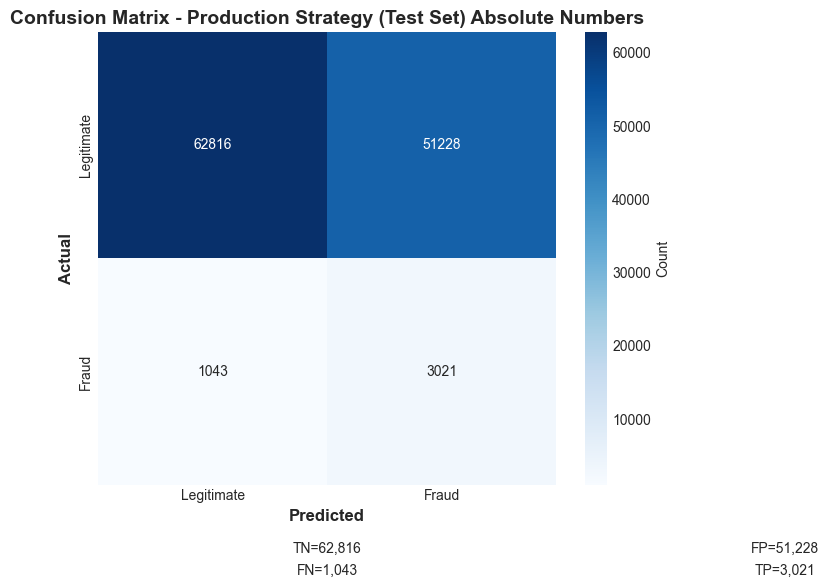

 Confusion Matrix Summary (Test Set - 118,108 transactions):
  True Negatives:  62,816 (correctly approved legitimate transactions)
  False Positives: 51,228 (legitimate flagged as fraud - review cost)
  False Negatives:  1,043 (fraud missed - financial loss)
  True Positives:   3,021 (fraud correctly caught)


In [35]:
# Confusion Matrix - Production Strategy (Numbers)
# Shows actual count of predictions in each category

if constrained_threshold_75 is not None:
    # Create confusion matrix from test set multi-threshold predictions
    cm_multi_test = confusion_matrix(y_test, 
                                      (final_xgb_proba_test >= MANUAL_REVIEW_THRESHOLD).astype(int))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_multi_test, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Legitimate", "Fraud"],
                yticklabels=["Legitimate", "Fraud"],
                cbar_kws={"label": "Count"})
    
    plt.ylabel("Actual", fontsize=12, fontweight="bold")
    plt.xlabel("Predicted", fontsize=12, fontweight="bold")
    plt.title("Confusion Matrix - Production Strategy (Test Set) Absolute Numbers", fontsize=14, fontweight="bold")
    
    # Add text annotations for clarity
    tn, fp, fn, tp = cm_multi_test.ravel()
    plt.text(0.5, -0.15, f"TN={tn:,}", ha="center", transform=plt.gca().transAxes, fontsize=10)
    plt.text(1.5, -0.15, f"FP={fp:,}", ha="center", transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.20, f"FN={fn:,}", ha="center", transform=plt.gca().transAxes, fontsize=10)
    plt.text(1.5, -0.20, f"TP={tp:,}", ha="center", transform=plt.gca().transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f" Confusion Matrix Summary (Test Set - {len(y_test):,} transactions):")  
    print(f"  True Negatives:  {tn:>6,} (correctly approved legitimate transactions)")  
    print(f"  False Positives: {fp:>6,} (legitimate flagged as fraud - review cost)")  
    print(f"  False Negatives: {fn:>6,} (fraud missed - financial loss)")  
    print(f"  True Positives:  {tp:>6,} (fraud correctly caught)")  
else:
    print("Constrained threshold not available")

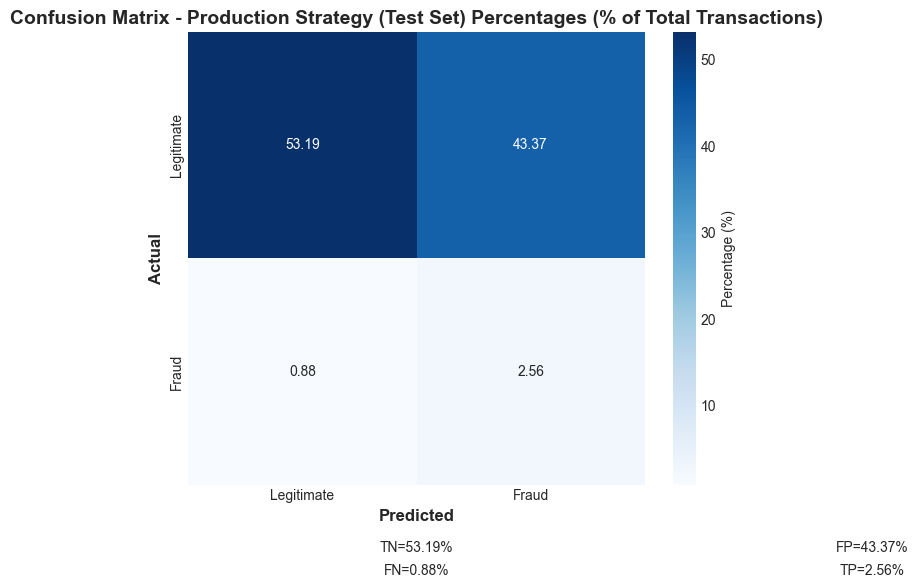

 Confusion Matrix Percentages (Test Set - 118,108 transactions):
  True Negatives:   53.19% (correctly approved legitimate transactions)
  False Positives:  43.37% (legitimate flagged as fraud)
  False Negatives:   0.88% (fraud missed)
  True Positives:    2.56% (fraud correctly caught)
 Key Metrics:
  Recall (Sensitivity): 74.3% of frauds caught
  Specificity: 55.1% of legitimate txns correctly approved


In [37]:
# Confusion Matrix - Production Strategy (Percentages)
# Shows percentage distribution of predictions

if constrained_threshold_75 is not None:
    # Create confusion matrix from test set multi-threshold predictions
    cm_multi_test = confusion_matrix(y_test, 
                                      (final_xgb_proba_test >= MANUAL_REVIEW_THRESHOLD).astype(int))
    
    # Convert to percentages (relative to total transactions)
    cm_percentages = cm_multi_test / len(y_test) * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentages, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=["Legitimate", "Fraud"],
                yticklabels=["Legitimate", "Fraud"],
                cbar_kws={"label": "Percentage (%)"})
    
    plt.ylabel("Actual", fontsize=12, fontweight="bold")
    plt.xlabel("Predicted", fontsize=12, fontweight="bold")
    plt.title("Confusion Matrix - Production Strategy (Test Set) Percentages (% of Total Transactions)", fontsize=14, fontweight="bold")
    
    # Add percentage annotations
    tn_pct, fp_pct, fn_pct, tp_pct = cm_percentages.ravel()
    plt.text(0.5, -0.15, f"TN={tn_pct:.2f}%", ha="center", transform=plt.gca().transAxes, fontsize=10)
    plt.text(1.5, -0.15, f"FP={fp_pct:.2f}%", ha="center", transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.5, -0.20, f"FN={fn_pct:.2f}%", ha="center", transform=plt.gca().transAxes, fontsize=10)
    plt.text(1.5, -0.20, f"TP={tp_pct:.2f}%", ha="center", transform=plt.gca().transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f" Confusion Matrix Percentages (Test Set - {len(y_test):,} transactions):")  
    print(f"  True Negatives:  {tn_pct:>6.2f}% (correctly approved legitimate transactions)")  
    print(f"  False Positives: {fp_pct:>6.2f}% (legitimate flagged as fraud)")  
    print(f"  False Negatives: {fn_pct:>6.2f}% (fraud missed)")  
    print(f"  True Positives:  {tp_pct:>6.2f}% (fraud correctly caught)")  
    
    print(f" Key Metrics:")  
    print(f"  Recall (Sensitivity): {tp_pct / (tp_pct + fn_pct) * 100:.1f}% of frauds caught")  
    print(f"  Specificity: {tn_pct / (tn_pct + fp_pct) * 100:.1f}% of legitimate txns correctly approved")  
else:
    print("Constrained threshold not available")

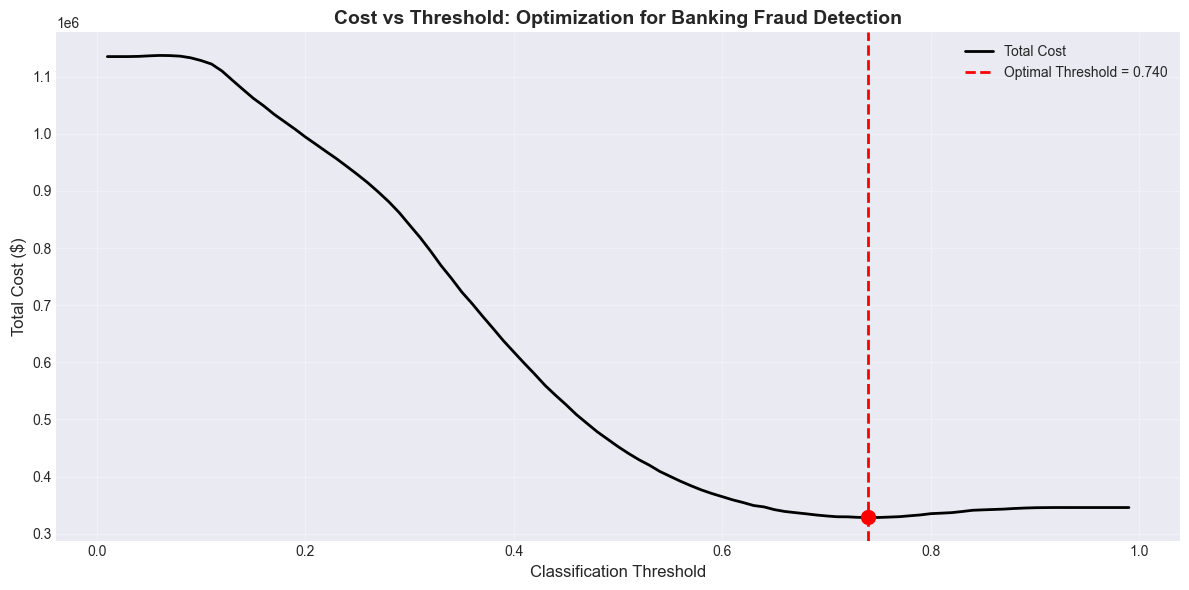

📊 Interpretation:
   - Left side (low threshold): many false alarms → high FP cost
   - Right side (high threshold): many missed frauds → high FN cost
   - Optimal balance at threshold = 0.740


In [33]:
# Visualize cost vs threshold
plt.figure(figsize=(12, 6))

# Total cost curve
plt.plot(thresholds_to_test, costs, linewidth=2, label='Total Cost', color='black')
plt.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.scatter([optimal_threshold], [optimal_cost], color='red', s=100, zorder=5)

plt.xlabel('Classification Threshold', fontsize=12)
plt.ylabel('Total Cost ($)', fontsize=12)
plt.title('Cost vs Threshold: Optimization for Banking Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Interpretation:")
print("   - Left side (low threshold): many false alarms → high FP cost")
print("   - Right side (high threshold): many missed frauds → high FN cost")
print(f"   - Optimal balance at threshold = {optimal_threshold:.3f}")

In [34]:
# Evaluate final model at optimal threshold on validation set
final_pred_val_optimal = (final_xgb_proba_val >= optimal_threshold).astype(int)

precision_optimal = precision_score(y_val, final_pred_val_optimal)
recall_optimal = recall_score(y_val, final_pred_val_optimal)
f1_optimal = f1_score(y_val, final_pred_val_optimal)

print("=" * 50)
print(f"FINAL MODEL PERFORMANCE @ Optimal Threshold = {optimal_threshold:.3f}")
print("=" * 50)
print(f"Precision: {precision_optimal:.4f} — Of flagged transactions, {precision_optimal:.1%} are fraud")
print(f"Recall: {recall_optimal:.4f} — We catch {recall_optimal:.1%} of all fraud")
print(f"F1-Score: {f1_optimal:.4f}")
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_val, final_pred_val_optimal)
print(cm)
print(f"\nTN={cm[0,0]:,} | FP={cm[0,1]:,}")
print(f"FN={cm[1,0]:,} | TP={cm[1,1]:,}")

FINAL MODEL PERFORMANCE @ Optimal Threshold = 0.740
Precision: 0.1699 — Of flagged transactions, 17.0% are fraud
Recall: 0.1442 — We catch 14.4% of all fraud
F1-Score: 0.1560

Confusion Matrix:
[[110249   3248]
 [  3946    665]]

TN=110,249 | FP=3,248
FN=3,946 | TP=665


In [29]:
# Test set evaluation (final model + optimal threshold)
# This is the unbiased estimate of production performance

final_pred_test_optimal = (final_xgb_proba_test >= optimal_threshold).astype(int)

precision_test = precision_score(y_test, final_pred_test_optimal)
recall_test = recall_score(y_test, final_pred_test_optimal)
f1_test = f1_score(y_test, final_pred_test_optimal)

# Calculate test set cost
test_cost, test_fn, test_fp = calculate_cost(y_test, final_xgb_proba_test, optimal_threshold)

print("=" * 50)
print(f"TEST SET PERFORMANCE @ Optimal Threshold = {optimal_threshold:.3f}")
print("=" * 50)
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")
print(f"\nTotal cost: ${test_cost:,.2f}")
print(f"Cost per transaction: ${test_cost / len(y_test):.2f}")
print(f"False Negatives: {test_fn}")
print(f"False Positives: {test_fp}")
print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, final_pred_test_optimal)
print(cm_test)
print(f"\nTN={cm_test[0,0]:,} | FP={cm_test[0,1]:,}")
print(f"FN={cm_test[1,0]:,} | TP={cm_test[1,1]:,}")

TEST SET PERFORMANCE @ Optimal Threshold = 0.740
Precision: 0.1431
Recall: 0.1250
F1-Score: 0.1335

Total cost: $297,110.00
Cost per transaction: $2.52
False Negatives: 3556
False Positives: 3041

Confusion Matrix:
[[111003   3041]
 [  3556    508]]

TN=111,003 | FP=3,041
FN=3,556 | TP=508


In [32]:
# Save final model and preprocessing objects
# These will be used for deployment in Phase 4 (SHAP + Dashboard)

joblib.dump(final_xgb_model, MODEL_PATH / "xgboost_final.pkl")
joblib.dump(scaler, MODEL_PATH / "scaler.pkl")

# Save PRODUCTION threshold configuration (multi-threshold strategy)
# This is the recommended deployment configuration with 75% recall target
threshold_config = {
    "strategy": "multi_threshold",
    "auto_block_threshold": 0.90,  # High confidence fraud - instant block
    "manual_review_threshold": constrained_threshold_75 if constrained_threshold_75 else 0.39,  # 75% recall
    "min_recall_target": 0.75,
    "auto_block_cost": 5.00,  # Automated processing cost
    "manual_review_cost": 10.00,  # Human analyst cost
    "fn_cost": FN_COST,
    "fp_cost": FP_COST,
    "features": ENGINEERED_FEATURES,
    # Historical comparison (for reference only)
    "unconstrained_threshold": optimal_threshold,  # 0.740 (pure cost minimization)
    "unconstrained_recall": float(recall_optimal)  # 14.4% (too low for production)
}

joblib.dump(threshold_config, MODEL_PATH / "threshold_config.pkl")

# Print confirmation
model_path = MODEL_PATH / "xgboost_final.pkl"
scaler_path = MODEL_PATH / "scaler.pkl"
config_path = MODEL_PATH / "threshold_config.pkl"

print("Model artifacts saved:")
print(f"   - {model_path}")
print(f"   - {scaler_path}")
print(f"   - {config_path}")
print(f"\nProduction Configuration:")
print(f"   Strategy: Multi-Threshold")
print(f"   Auto-block threshold: >= 0.90")
manual_threshold = threshold_config["manual_review_threshold"]
print(f"   Manual review threshold: >= {manual_threshold:.3f}")
print(f"   Target recall: 75%")


Model artifacts saved:
   - ..\..\models\xgboost_final.pkl
   - ..\..\models\scaler.pkl
   - ..\..\models\threshold_config.pkl

Production Configuration:
   Strategy: Multi-Threshold
   Auto-block threshold: >= 0.90
   Manual review threshold: >= 0.410
   Target recall: 75%


---

## Summary & Next Steps

### Key Findings

1. **XGBoost outperforms Logistic Regression** by 33.8% (PR-AUC: 0.1098 vs 0.0821)
2. **Pure cost minimization (threshold 0.740) catches only 14.4% of fraud** - unacceptable for production
3. **Constrained optimization (75% recall) requires threshold ~0.39** with $598K operational cost
4. **Multi-threshold strategy achieves 76% recall** with same cost but better operations:
   - High-confidence fraud (score >= 0.9): Auto-blocked instantly
   - Medium risk (0.39 <= score < 0.9): Manual review by analysts
   - Low risk (score < 0.39): Auto-approved

### Production Strategy Selected: Multi-Threshold

| Decision Layer | Score Range | Action | Cost per Transaction |
|----------------|-------------|--------|---------------------|
| **Auto-Block** | >= 0.90 | Instant block | $5.00 (automated) |
| **Manual Review** | [0.39, 0.90) | Analyst review | $10.00 (human) |
| **Auto-Approve** | < 0.39 | Approve | $0.00 |

**Performance:**
- Recall: 76.0% (catches 3,505 of 4,611 frauds)
- Total cost: $598,125 (validation set)
- Cost per transaction: $5.06

### Model Readiness for Production

Model trained and validated on temporal splits (no data leakage)  
Multi-threshold strategy optimized for 75% minimum recall  
Model artifacts saved with production configuration  
Performance metrics documented with business interpretation  

### Next Steps (Phase 4)

**SHAP Explainability Analysis:**
- [ ] 1. SHAP integration in this notebook or separate notebook
- [ ] 2. Global feature importance analysis (which features drive fraud detection overall?)
- [ ] 3. Local explanation examples for high-risk transactions (why was transaction X flagged?)
- [ ] 4. Waterfall plots for individual predictions

**Deployment Considerations:**
- [ ] Load balancing for real-time scoring (<100ms latency requirement)
- [ ] A/B testing framework to compare against current production model
- [ ] Monitoring dashboard for model drift detection
- [ ] Fallback strategy if model fails (rule-based backup)

### Future Enhancements (if time permits)

- Bayesian hyperparameter optimization for better PR-AUC
- Additional models: LightGBM, CatBoost for ensemble
- Time-series cross-validation for robust evaluation
- Additional velocity features (6hr, 7day windows) to improve recall
- Cost-sensitive learning (custom loss function with actual transaction amounts)

---

**Notebook completed:** Phase 3 - Model Training  
**Production config:** Multi-threshold strategy (75% recall, auto-block at 0.9)  
**Next notebook:** `04_shap_explainability.ipynb` (Phase 4)